In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from PIL import Image

import time
import os

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

## HYPER PARAMS

In [3]:
test_number = "Test1"

dataroot = '../data/dogscats/train/dogs/'
saveroot = '../GAN_Images/'

max_levels = 6
image_size = 128

batch_size = 48
workers = 4

nz = 150
nc = 3
ngf = 6
ndf = 6

lr = 0.0001
beta = (0.5, 0.999)

num_epochs = 1200
num_steps = 200
k = 1

## DATASET

In [4]:
class SquashTransfrom:
    def __call__(self, inputs):
        return 2*inputs-1

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.CenterCrop(image_size),
    torchvision.transforms.ToTensor(),
    SquashTransfrom()
])

In [6]:
class DogsDataset(torch.utils.data.Dataset):
    def __init__ (self, root, transform):
        self.root = root
        self.transform = transform
        self.images = os.listdir(root)
        
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.root, self.images[index]))
        if self.transform:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.images)

In [7]:
train_ds = DogsDataset(dataroot, transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=workers, pin_memory=True)

In [8]:
print("Training Set:",len(train_ds))

for xb in train_dl:
    xb = xb.to(device)
    print(xb.shape, xb.min(), xb.max())
    break

Training Set: 11500
torch.Size([48, 3, 128, 128]) tensor(-1., device='cuda:0') tensor(1., device='cuda:0')


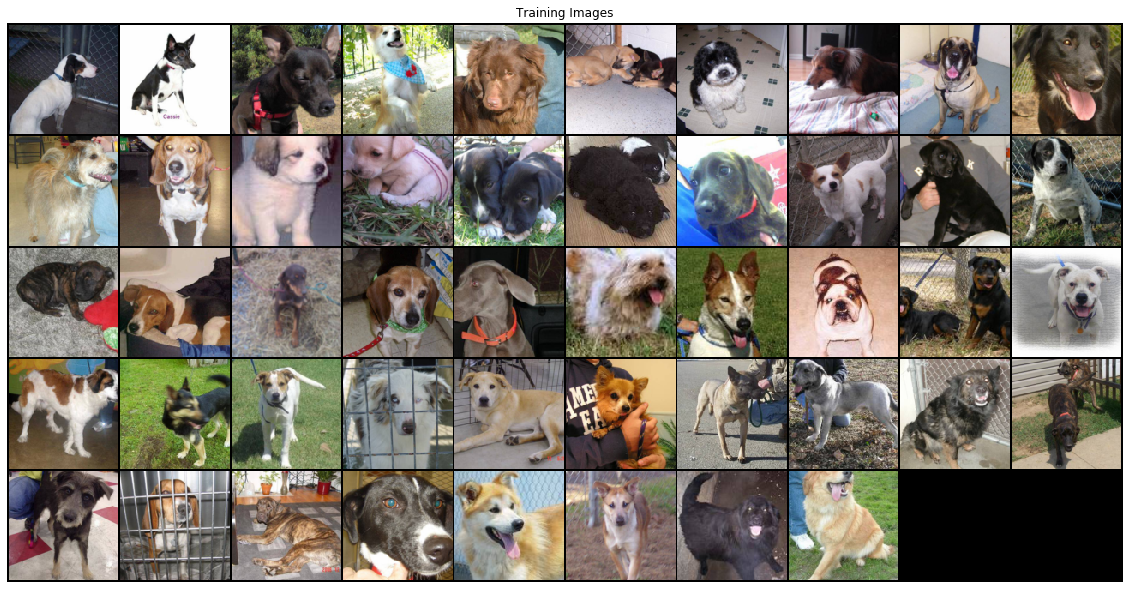

In [9]:
# Plot some training images
real_batch = next(iter(train_dl))

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Training Images")

plt.imshow(
        torchvision.utils.make_grid(
            real_batch.to(device),padding=2,normalize=True,nrow=10).cpu().permute(1,2,0)
)

plt.show();

## Pixelwise Normalization

##### PIXELWISE FEATURE VECTOR NORMALIZATION IN GENERATOR


$$ b_{x, y}=a_{x, y} / \sqrt{\frac{1}{N} \sum_{j=0}^{N-1}\left(a_{x, y}^{j}\right)^{2}+\epsilon} $$

In [10]:
class PixelNormLayer(torch.nn.Module):
    def __init__(self):
        super(PixelNormLayer, self).__init__()
        
    def forward(self,x):
        return x / torch.sqrt(
            torch.mean(x **2, dim=1, keepdim=True) + 1e-8
        )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


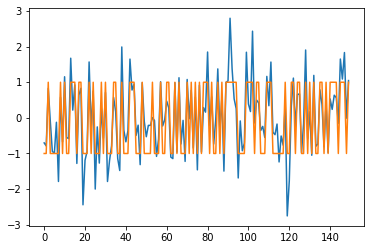

In [11]:
sample = torch.tensor(torch.randn((150,1)))

l = PixelNormLayer()
norm_sample = l(sample)

plt.figure()
plt.plot(sample)
plt.plot(norm_sample)
plt.show()

## Weights Normalization

##### EQUALIZED LEARNING RATE

$$ \hat{w}_{i}=w_{i} / c $$

$$ c = \sqrt{ 2 / N } $$

In [12]:
class WScaleLayer(torch.nn.Module):
    def __init__(self, incoming, gain=2):
        super(WScaleLayer, self).__init__()
        self.gain = gain
        self.scale = (self.gain / incoming.weight[0].numel()) ** 0.5

    def forward(self, input):
        return input * self.scale

## MODEL

In [13]:
def GConvBlock(in_channels, out_channels, kernel_size, stride, padding, bias):
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias=bias),
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU(inplace=True),
            PixelNormLayer()
    )

In [14]:
def DConvBlock(in_channels, out_channels, kernel_size, stride, padding, bias):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias=bias),
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
    )

In [15]:
class Generator(torch.nn.Module):

    def __init__(self):

        super(Generator, self).__init__()
        
        self.blocks = torch.nn.ModuleList()
        self.toRGBs = torch.nn.ModuleList()
        
        # first conv block
        self.blocks.append(
            torch.nn.Sequential(
                GConvBlock(
                    in_channels=nz,
                    out_channels=ngf * 48,
                    kernel_size=4,
                    stride=1,
                    padding=0,
                    bias=False
                ),
                GConvBlock(
                    in_channels=ngf * 48,
                    out_channels=ngf * 32,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                    bias=False
                )
            )
        )

        # growing conv blocks: 4 * 4, 8 * 8, 16 * 16, 32 * 32, 64 * 64
        i = 5  # channels sentinent
        j = 4  # size sentinent
        
        while j <= image_size:
            
            in_channels = int(
                ngf * ( 2 ** i )
            )  # 32 => 16 => 8 => 4 => 2
            out_channels = int(
                ngf * ( 2 ** (i - 1) )
            )  # 16 => 8  => 4 => 2 => 1
            
            self.blocks.append(
                torch.nn.Sequential(
                    GConvBlock(
                        in_channels=in_channels,  
                        out_channels=in_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False
                    ),
                    GConvBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    )
                )
            )
            
            self.toRGBs.append(
                torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(
                        in_channels=in_channels,
                        out_channels=nc,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    ),
                    torch.nn.Tanh()
                )
            )
            
            i = i - 1
            j = j * 2
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(
                    m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(
                        m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(
                    m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

    # level = 1: 4x4, 2: 8x8, 3: 16x16, 4: 32x32, 5:64x64
    def forward(self, inputs, level):
        
        alpha = False  # level - int(level)
        level = min(int(ceil(level)), max_levels)
        
        feature_map = self.blocks[0](inputs)
                
        for i in range(1, level):

            feature_map = self.blocks[i](
                feature_map)
                        
            # alpha transition
            if level > 1 and i == level-1 and alpha != 0:
        
                # upsample 2x
#                 prev_output = torch.nn.functional.upsample(
#                     feature_map,
#                     scale_factor=2
#                 )
                        
                prev_output = self.toRGBs[i](
                    feature_map)

        output = self.toRGBs[level-1](feature_map)
        
        if alpha != 0:
            return output * alpha + prev_output * ( 1 - alpha )
        else:
            return output
        

In [16]:
class Discriminator(torch.nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()
        
        self.fromRGBs = torch.nn.ModuleList()
        self.blocks = torch.nn.ModuleList()

        # opposite growing conv blocks: 4 * 4, 8 * 8, 16 * 16, 32 * 32, 64 * 64
        i = 0  # channels sentinent
        j = 4  # size sentinent
        
        while j <= image_size:
            
            in_channels = int(
                ndf * ( 2 ** i )
            )  # 1 => 2 => 4 => 8  => 16
            out_channels =int(
                ndf * ( 2 ** (i + 1) )
            )  # 2 => 4 => 8 => 16 => 32
            
            self.fromRGBs.append(
                torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_channels=nc,
                        out_channels=in_channels,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    ),
                    torch.nn.LeakyReLU(
                        negative_slope=0.2,
                        inplace=True
                    )
                )
            )
            
            self.blocks.append(
                torch.nn.Sequential(
                    DConvBlock(
                        in_channels=in_channels,
                        out_channels=in_channels,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        bias=False
                    ),
                    DConvBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False
                    )
                )
            )
            
            i = i + 1
            j = j * 2
        
        # add last block
        self.blocks.append(
            torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=ndf * ( 2 ** (i + 1) ),
                    out_channels=1,
                    kernel_size=2,
                    stride=1,
                    padding=0,
                    bias=False
                ),
                torch.nn.Sigmoid()
            )
        )
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

    # level = 1: 4x4, 2: 8x8, 3: 16x16, 4: 32x32, 5:64x64
    def forward(self, inputs, level): 
        
        alpha = False  # level - int(level)
        level = min(int(ceil(level)), max_levels)
        
        feature_map = self.fromRGBs[max_levels - level](inputs)
        feature_map = self.blocks[max_levels - level](feature_map)
        
        # alpha transition
        if level > 1 and alpha != 0:
            
            # downsample 0.5x
            prev_input = torch.nn.functional.avg_pool2d(
                inputs,
                kernel_size=2,
                stride=2
            )
            
            prev_feature_map = self.fromRGBs[max_levels - level + 1](prev_input)
            
            # alpha merge
            feature_map = alpha * feature_map + ( 1 - alpha ) * prev_feature_map
        
        for i in range(max_levels - level + 1, max_levels):            
            
            feature_map = self.blocks[i](feature_map)
        
        # standard deviation per mini batch
        stdv = torch.std(feature_map, dim=0)

        # concatenate feature map and stdv
        y = torch.cat(
            (
                feature_map,
                stdv.unsqueeze(0).expand_as(
                    feature_map
                )
            ),
            dim=1
        )

        # pass through last layer
        ret = self.blocks[-1](y).view(-1, 1)

        return ret

In [17]:
discriminator = Discriminator()
generator = Generator()

In [18]:
discriminator, generator

(Discriminator(
   (fromRGBs): ModuleList(
     (0): Sequential(
       (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
     )
     (1): Sequential(
       (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
     )
     (2): Sequential(
       (0): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
     )
     (3): Sequential(
       (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
     )
     (4): Sequential(
       (0): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
     )
     (5): Sequential(
       (0): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
     )
   )
   (

## Unit Testing

In [19]:
for i in np.arange(1.00009, max_levels+0.2, 0.1):
    
    rounded_level = min(int(ceil(i)), max_levels)
        
    out = generator(torch.zeros(batch_size, nz, 1, 1), level=i)
    
    assert out.shape == (batch_size, 3, 4 * (2 ** (rounded_level-1)), 4 * (2 ** (rounded_level-1))), "G Output Shape={}".format(out.shape)

    valid = discriminator(out, level=i)
    
    assert valid.shape == (batch_size, 1), "D Output Shape={}".format(valid.shape)
    
    print(
        'Verified Size {} x {} \t @ Level {}'.format(
            4 * ( 2 ** (rounded_level-1)),
            4 * ( 2 ** (rounded_level-1)),
            i
        )
    )

Verified Size 8 x 8 	 @ Level 1.00009
Verified Size 8 x 8 	 @ Level 1.10009
Verified Size 8 x 8 	 @ Level 1.20009
Verified Size 8 x 8 	 @ Level 1.3000900000000002
Verified Size 8 x 8 	 @ Level 1.4000900000000003
Verified Size 8 x 8 	 @ Level 1.5000900000000004
Verified Size 8 x 8 	 @ Level 1.6000900000000005
Verified Size 8 x 8 	 @ Level 1.7000900000000005
Verified Size 8 x 8 	 @ Level 1.8000900000000006
Verified Size 8 x 8 	 @ Level 1.9000900000000007
Verified Size 16 x 16 	 @ Level 2.000090000000001
Verified Size 16 x 16 	 @ Level 2.1000900000000007
Verified Size 16 x 16 	 @ Level 2.200090000000001
Verified Size 16 x 16 	 @ Level 2.300090000000001
Verified Size 16 x 16 	 @ Level 2.4000900000000014
Verified Size 16 x 16 	 @ Level 2.500090000000001
Verified Size 16 x 16 	 @ Level 2.6000900000000016
Verified Size 16 x 16 	 @ Level 2.700090000000001
Verified Size 16 x 16 	 @ Level 2.8000900000000017
Verified Size 16 x 16 	 @ Level 2.9000900000000014
Verified Size 32 x 32 	 @ Level 3.0000

In [20]:
discriminator = discriminator.to(device)
generator = generator.to(device)

## LOSS FUNCTION/ OPTIMIZER

In [21]:
criterion = torch.nn.BCELoss()

opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)

## HELPERS

In [22]:
real_labels = torch.ones((batch_size, 1)).to(device)
fake_labels = torch.zeros((batch_size, 1)).to(device)

print(real_labels.shape, fake_labels.shape)

torch.Size([48, 1]) torch.Size([48, 1])


In [23]:
fixed_noise = torch.randn((batch_size, nz, 1, 1)).to(device)

## PRE-FLIGHT CHECK

## TRAIN

In [24]:
def train_discriminator(images, level):
    opt_d.zero_grad()
    
    real_images = images.to(device)
    fake_images = generator(torch.randn(batch_size,nz,1,1).to(device), level).detach()
    
    real_outputs = discriminator(real_images, level)
    fake_outputs = discriminator(fake_images, level)
    
    real_loss = criterion(real_outputs, real_labels)
    fake_loss = criterion(fake_outputs, fake_labels)
    real_loss.backward()
    fake_loss.backward()
    
    opt_d.step()
    
    return real_loss + fake_loss

In [25]:
def train_genarator(level):
    opt_g.zero_grad()
    
    images = generator(torch.randn(batch_size,nz,1,1).to(device), level)
    
    outputs = discriminator(images, level)
    
    loss = criterion(outputs, real_labels)
    loss.backward()
    
    opt_g.step()
    
    return loss

#### Control Progressive Growing

In [26]:
# standardize to range [0 - 1] then scale to range [1, max_levels]
def updateLevel(epoch, step, total_epochs, total_steps, max_levels):
    
    total_spectrum = total_epochs * total_steps
    
    current_point = epoch * total_steps + step
    
    return min( 
        max( 
            (current_point / total_spectrum ) * max_levels, 4), max_levels)

In [27]:
ret = []
res = []

for i in range(50):
    for j in range(20):
        level = updateLevel(i, j, 50, 20, max_levels)
        ret.append(level)
        res.append(2 ** (ceil(level + 1.001)))

print(ret, res)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

#### Downsample Image Batch

In [28]:
def downsampleMiniBatch(images, level):
    
    level = min(int(ceil(level)), max_levels)

    d = 4 * (2 ** (level - 1))
        
    return torch.nn.functional.adaptive_avg_pool2d(
                images,
                output_size=d
            )

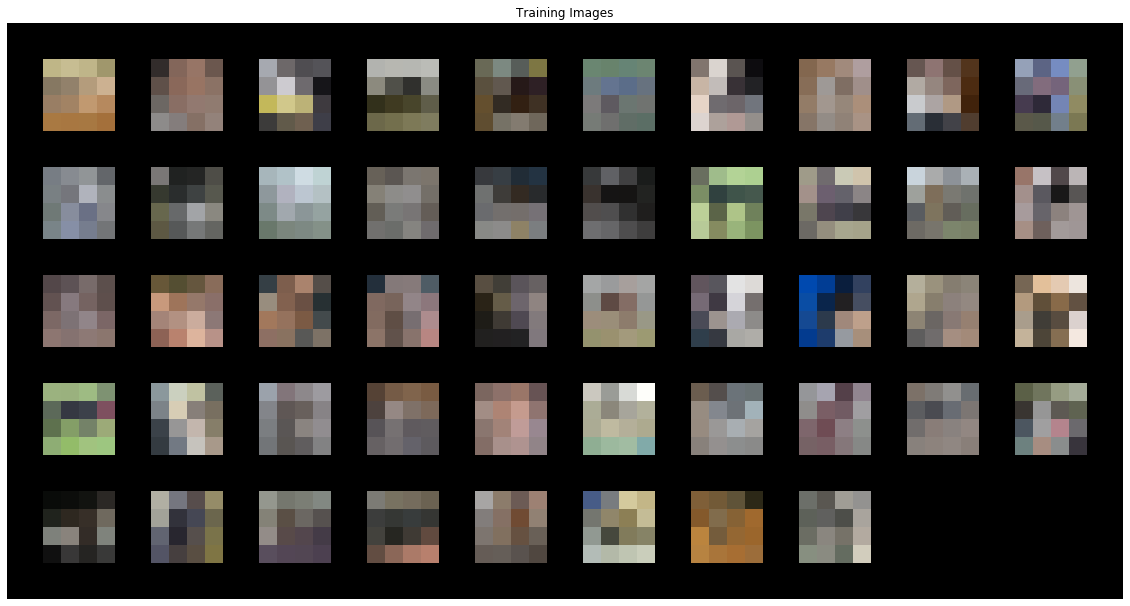

In [29]:
# Plot some training images at 4 x 4 resolution
real_batch = next(iter(train_dl))

resized_batch = downsampleMiniBatch(real_batch, 1)

plt.figure(figsize=(20, 20))

plt.axis("off")

plt.title("Training Images")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            resized_batch,
            padding=2,
            normalize=True,
            nrow=10
        ),
        (1,2,0)
    )
)

plt.show();

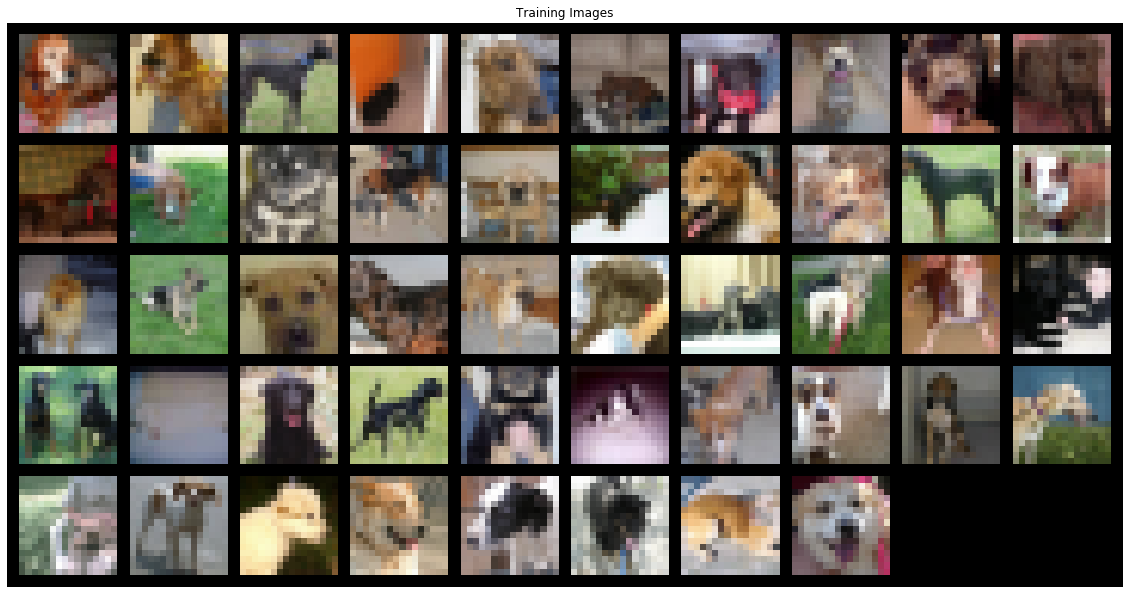

In [30]:
# Plot some training images at 16 x 16 resolution
real_batch = next(iter(train_dl))

resized_batch = downsampleMiniBatch(real_batch, 3)

plt.figure(figsize=(20, 20))

plt.axis("off")

plt.title("Training Images")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            resized_batch,
            padding=2,
            normalize=True,
            nrow=10
        ),
        (1,2,0)
    )
)

plt.show();

## TRAIN

In [31]:
start_time = time.time()

loss_D = []
loss_G = []

for epoch in range(num_epochs):
    epoch += 1
    loss_d = 0.0
    loss_g = 0.0
    
    for i, (images) in enumerate(train_dl):
        if i==num_steps:
            break
        level = updateLevel(epoch, i, num_epochs, num_steps, max_levels) + 0.00009
        
        for _ in range(k):
            images = downsampleMiniBatch(images, level)
            loss_d += train_discriminator(images, level)
        loss_g += train_genarator(level)
    loss_D.append(loss_d/i)
    loss_G.append(loss_g/i)
    
    if epoch % 10 == 0:
        print(f"{epoch}/{num_epochs} | LEVEL: {level} | G_LOSS: {loss_g/i:.4f} | D_LOSS: {loss_d/i:.4f} | TIME: {time.time() - start_time:.0f}sec")
        sample = generator(fixed_noise, ceil(level)).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 3, image_size, image_size), nrow=8, pad_value=1, normalize=True, range=(-1, 1))   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join(saveroot, '20210115_PGGAN_DOGS_{}_{}.jpg'.format(test_number, str(epoch).zfill(3))))        
    
print(f"TOTAL TIME: {time.time() - start_time:.0f}sec")

10/1200 | LEVEL: 4.00009 | G_LOSS: 7.4701 | D_LOSS: 0.0563 | TIME: 124sec
20/1200 | LEVEL: 4.00009 | G_LOSS: 6.8507 | D_LOSS: 0.0644 | TIME: 239sec
30/1200 | LEVEL: 4.00009 | G_LOSS: 10.9433 | D_LOSS: 0.0001 | TIME: 356sec
40/1200 | LEVEL: 4.00009 | G_LOSS: 18.0238 | D_LOSS: 0.0000 | TIME: 484sec
50/1200 | LEVEL: 4.00009 | G_LOSS: 20.0940 | D_LOSS: 0.0000 | TIME: 606sec
60/1200 | LEVEL: 4.00009 | G_LOSS: 8.7677 | D_LOSS: 0.0017 | TIME: 732sec
70/1200 | LEVEL: 4.00009 | G_LOSS: 10.7270 | D_LOSS: 0.1115 | TIME: 866sec
80/1200 | LEVEL: 4.00009 | G_LOSS: 9.5482 | D_LOSS: 0.0264 | TIME: 1006sec
90/1200 | LEVEL: 4.00009 | G_LOSS: 13.6256 | D_LOSS: 0.0000 | TIME: 1141sec
100/1200 | LEVEL: 4.00009 | G_LOSS: 26.9326 | D_LOSS: 0.0000 | TIME: 1274sec
110/1200 | LEVEL: 4.00009 | G_LOSS: 37.6195 | D_LOSS: 0.0000 | TIME: 1406sec
120/1200 | LEVEL: 4.00009 | G_LOSS: 42.9023 | D_LOSS: 0.0000 | TIME: 1544sec
130/1200 | LEVEL: 4.00009 | G_LOSS: 45.3104 | D_LOSS: 0.0000 | TIME: 1679sec
140/1200 | LEVEL: 4

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)


570/1200 | LEVEL: 4.00009 | G_LOSS: 58.7556 | D_LOSS: 0.0000 | TIME: 7424sec
580/1200 | LEVEL: 4.00009 | G_LOSS: 58.7103 | D_LOSS: 0.0000 | TIME: 7556sec
590/1200 | LEVEL: 4.00009 | G_LOSS: 58.7704 | D_LOSS: 0.0000 | TIME: 7686sec
600/1200 | LEVEL: 4.00009 | G_LOSS: 58.7306 | D_LOSS: 0.0000 | TIME: 7818sec


OSError: [Errno 12] Cannot allocate memory

In [ ]:
plt.figure()

plt.plot(loss_D, label='LOSS D')
plt.plot(loss_G, label='LOSS G')
plt.legend()
plt.savefig('./PGGAN_DOGS_{}.png'.format(test_number))
plt.show()

In [ ]:
torch.save(generator.state_dict(), './PGGAN_DOGS_{}_Generator_e200.pt'.format(test_number))
torch.save(discriminator.state_dict(), './PGGAN_DOGS_{}_Discriminator_e200.pt'.format(test_number))

In [ ]:
# # LOAD MODEL
# discriminator.load_state_dict(torch.load('./PGGAN_DOGS_{}_Discriminator.pt'.format(test_number)))
# generator.load_state_dict(torch.load('./PGGAN_DOGS_{}_Generator.pt'.format(test_number)))